# Rossmann Store Sales

- Bases de dados: https://www.kaggle.com/c/rossmann-store-sales/data


O uso de Machine Learning é importante para aumentar a competitividade das empresas ao prever vendas futuras. Essas bases de dados contém históricos de vendas de 1.115 lojas Rossmann.

**O objetivo deste projeto é prever vendas diárias futuras. Nele será utilizado a ferramenta Facebook Prophet que é um framework do Facebook utilizado para previsão de vendas e valores numéricos no geral.**

Modelos de previsão de vendas baseados em dados passados devem considerar o que chamamos de efeitos sazonais, que são efeitos como demanda, feriados, concorrência e promoções.

As base de dados contém histórico de transações e dados das lojas:

- **id**- identificador da transação (loja+data)
- **Store** - identificador único para cada loja
- **Sales** - o volume de negócios/vendas para um determinado dia (objetivo)
- **Customers** - o número de clientes em um determinado dia
- **Open** - um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
- **StateHoliday** - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. 
 - a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

- **SchoolHoliday** - feriado escolar
- **StoreType** - diferencia entre 4 modelos de loja diferentes: a, b, c, d
- **Assortment** - descreve um nível de sortimento: 
  - a = básico, b = extra, c = estendido
- **CompetitionDistance** - distância em metros até a loja concorrente mais próxima
- **CompetitionOpenSince[Month/Year]** - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
- **Promo** - indica se uma loja está realizando uma promoção naquele dia
- **Promo2** - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 
  - 0 = loja não está participando, 1 = loja está participando
- **Promo2Since[Year/Week]** - descreve o ano e a semana em que a loja começou a participar do Promo2
- **PromoInterval** - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja






## Importação das bibliotecas e base de dados

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

## Observando dados das vendas

In [ ]:
sales_train_df = pd.read_csv('train.csv')

In [ ]:
sales_train_df.shape

(1017209, 9)

In [ ]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
for i in ['DayOfWeek','Open','Promo','SchoolHoliday']:
  print(f'{i} values: {sales_train_df[i].unique()}')

DayOfWeek values: [5 4 3 2 1 7 6]
Open values: [1 0]
Promo values: [1 0]
SchoolHoliday values: [1 0]


In [ ]:
sales_train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


não há valores nulos

In [ ]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### Observando dados das lojas

In [ ]:
store_info_df = pd.read_csv('store.csv')

In [ ]:
store_info_df.shape

(1115, 10)

In [ ]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


há valores nulos

In [ ]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## **Análise exploratória dos dados**

### Dados das vendas

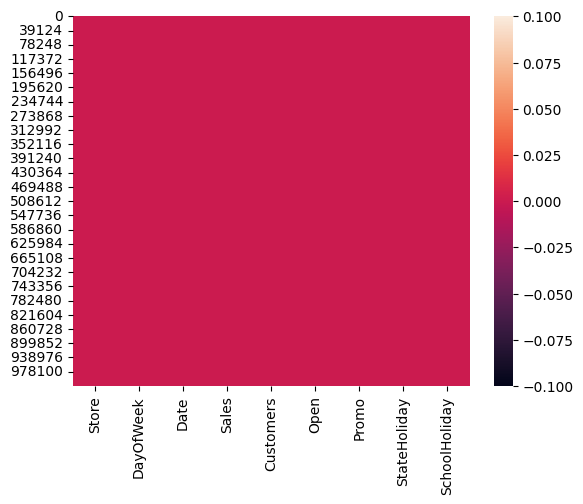

In [ ]:
sns.heatmap(sales_train_df.isnull());

In [ ]:
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'Sales'}>],
       [<Axes: title={'center': 'Customers'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'Promo'}>],
       [<Axes: title={'center': 'SchoolHoliday'}>, <Axes: >, <Axes: >]],
      dtype=object)

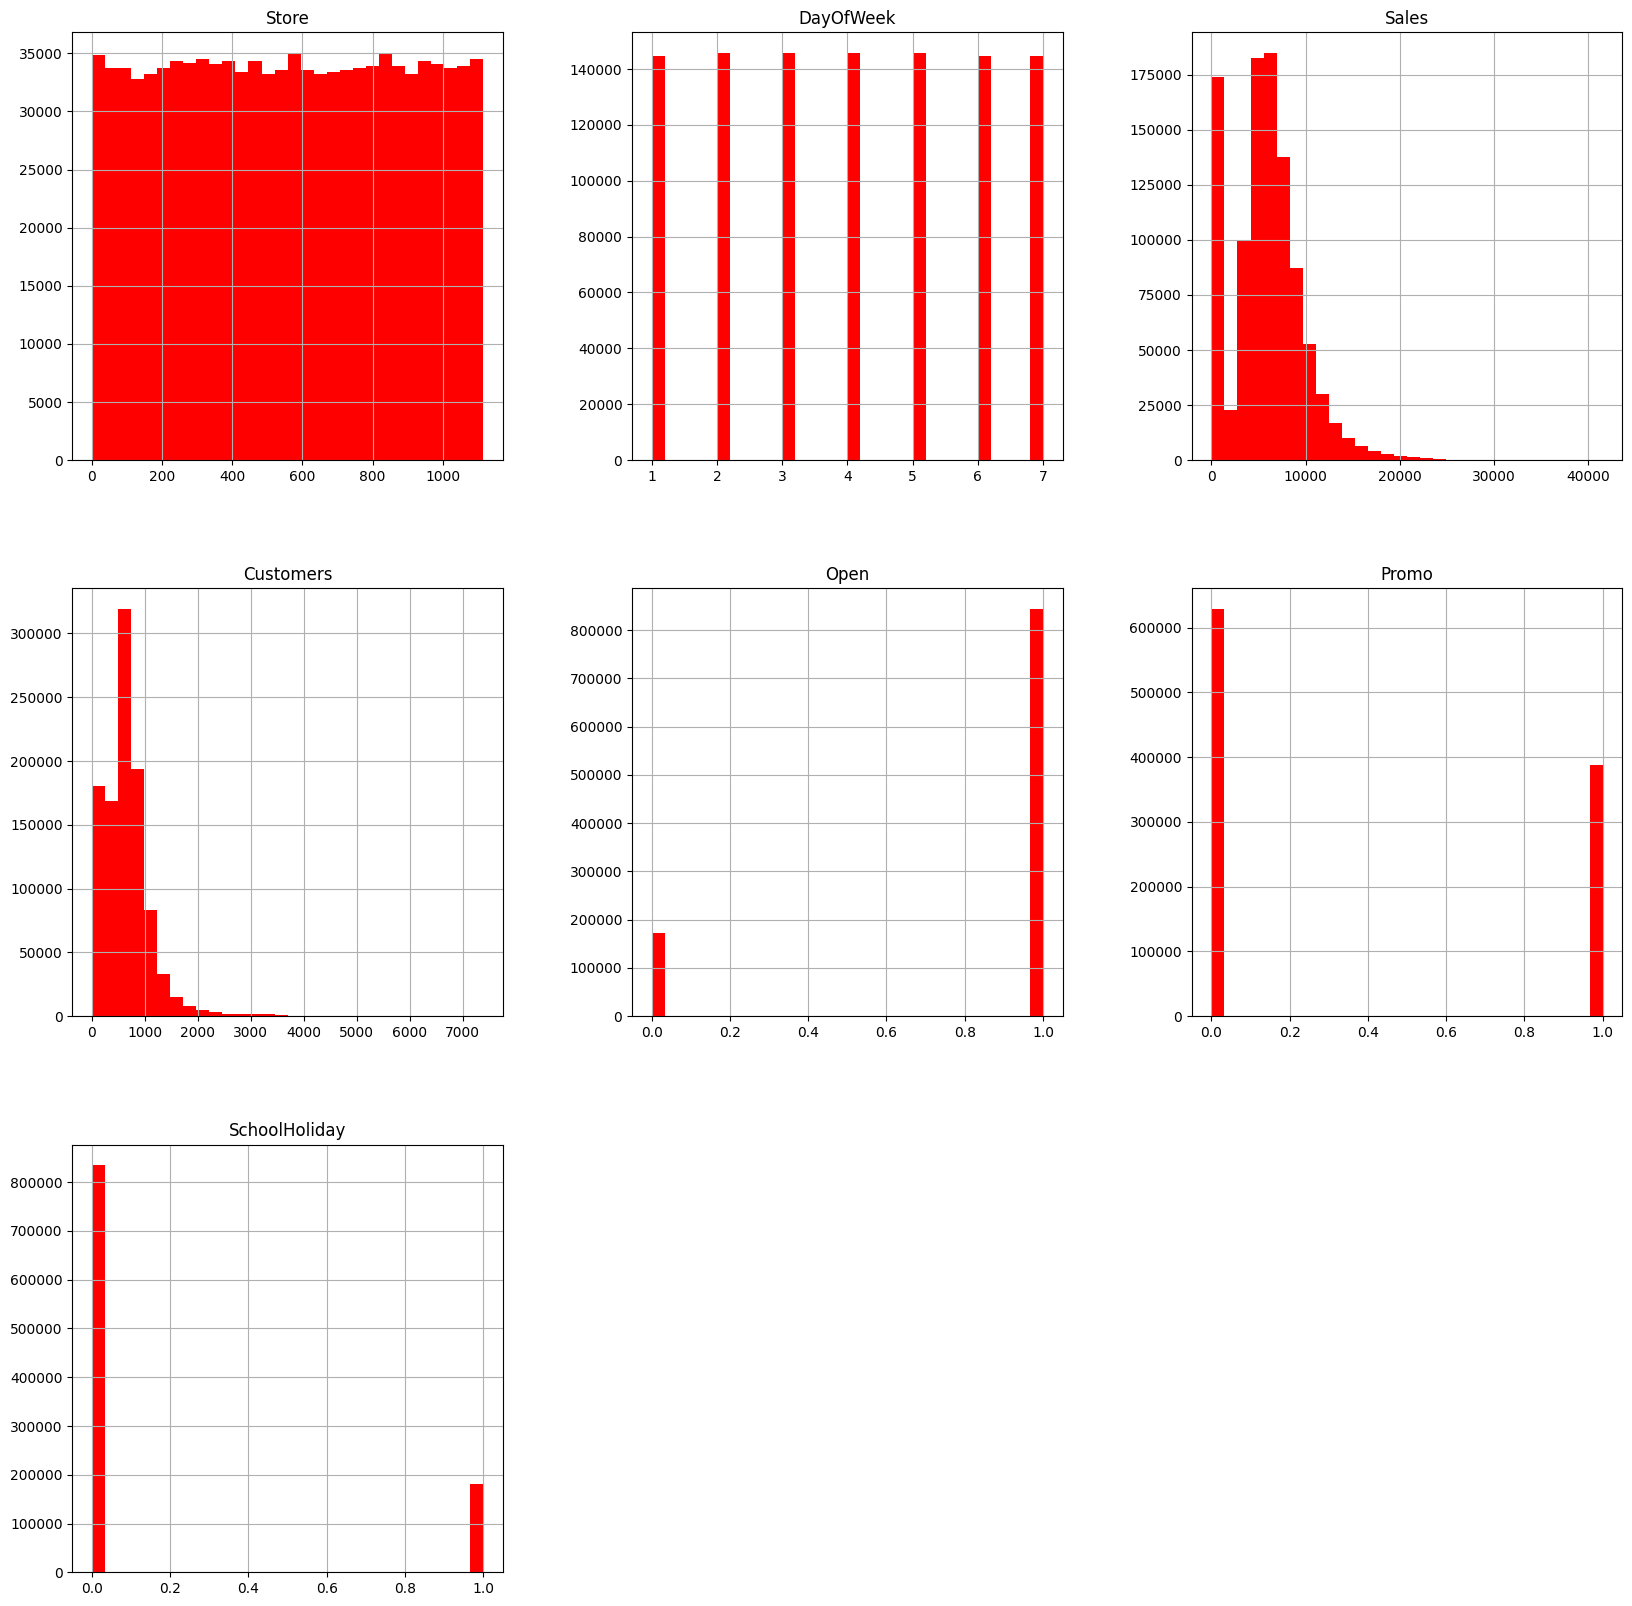

In [ ]:
sales_train_df.hist(bins = 30, figsize=(20, 20), color = 'r')

- a maioria das vendas estão próximas de 5 a 8000 euros
- em média há aproximadamente 600 clientes por dia
- havia promoção em mais da metade das vezes em que as lojas estavam abertas

In [ ]:
sales_train_df['Customers'].max() # número máximo de clientes em um dia

7388

Vamos gerar dois DataFrames. Um que contém somente as lojas que estavam abertas e outro somente com as lojas que estavam fechadas.

In [ ]:
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
print('Total = ', len(sales_train_df))
print('Número de lojas/dias fechado = ', len(closed_train_df))
print('Número de lojas/dias aberto = ', len(open_train_df))

Total =  1017209
Número de lojas/dias fechado =  172817
Número de lojas/dias aberto =  844392


In [ ]:
172817 / len(store_info_df) # média de dias em que as lojas estavam fechadas

154.99282511210762

In [ ]:
closed_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


Como nos dias em que as lojas estavam fechadas não há registro de vendas então não faz sentido utilizar essa parte dos dados.

In [ ]:
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [ ]:
sales_train_df.shape

(844392, 9)

In [ ]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [ ]:
sales_train_df.drop(['Open'], axis = 1, inplace=True)

In [ ]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [ ]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


- o número médio de clientes por dia é de 762 
- a média de vendas por dia é de 6955
- o maior volume de vendas em um único dia foi de 41551

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

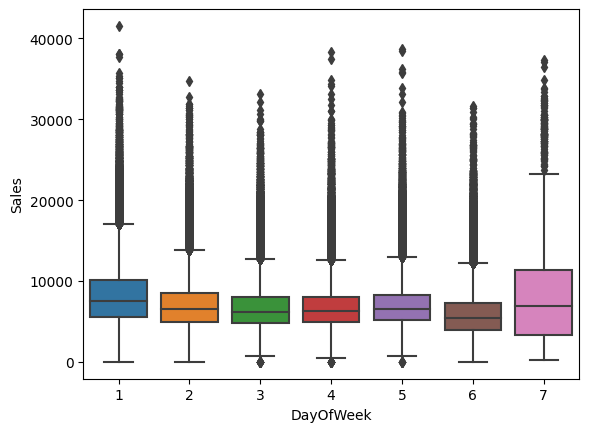

In [ ]:
sns.boxplot(data=sales_train_df, x="DayOfWeek", y="Sales")

- os dias com maiores valores de venda são segunda feira e domingo
- o dia menos lucrativo é a sábado
- o restante dos dias mantém uma média de vendas parecida e próximas a 6000 euros

<Axes: xlabel='Promo', ylabel='Sales'>

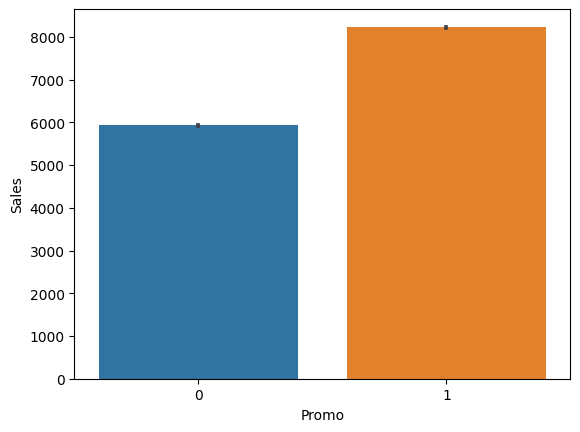

In [ ]:
sns.barplot(data=sales_train_df, x="Promo", y="Sales")

- quando as lojas estavam em promoção os volumes das vendas eram maiores

<Axes: xlabel='SchoolHoliday', ylabel='Sales'>

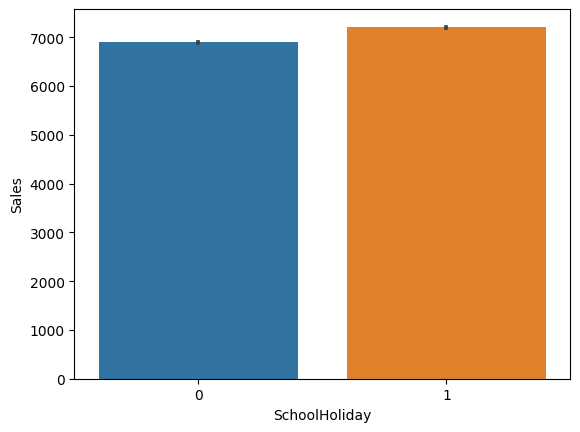

In [ ]:
sns.barplot(data=sales_train_df, x="SchoolHoliday", y="Sales")

- os feriados escolares parece não afetar os valores das vendas

### Dados das lojas

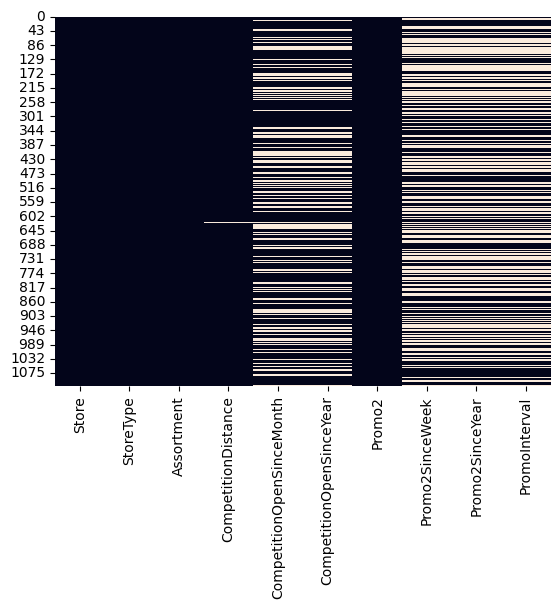

In [ ]:
sns.heatmap(store_info_df.isnull(), cbar=False);

In [ ]:
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_info_df[store_info_df['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_info_df[store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Em torno da metade das lojas (544) não estão participando de promoção adicional (Promo2). Quando Promo2 é 0 os valores para os outros atributos como Promo2SinceYear e Promo2SinceWeek não existem, pois não há promoção.

Como não faz sentido preencher essas colunas com a média de seus valores, então o que podemos fazer é atribuir 0 para todas elas.

In [ ]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in str_cols:
  store_info_df[str].fillna(0, inplace=True)

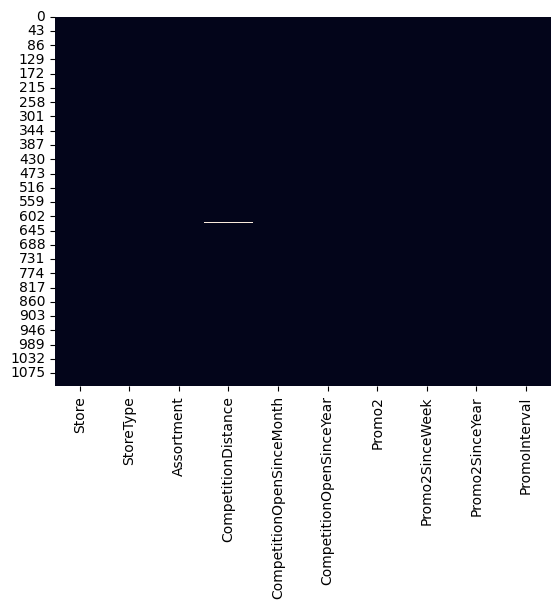

In [ ]:
sns.heatmap(store_info_df.isnull(), cbar = False);

Mas para o atributo CompetitionDistance é possível aplicar a média de seus valores nos registros ausentes.

In [ ]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

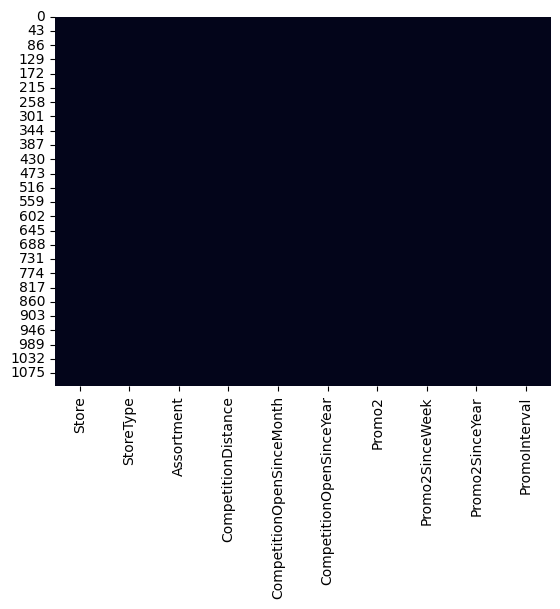

In [ ]:
sns.heatmap(store_info_df.isnull(), cbar = False);

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

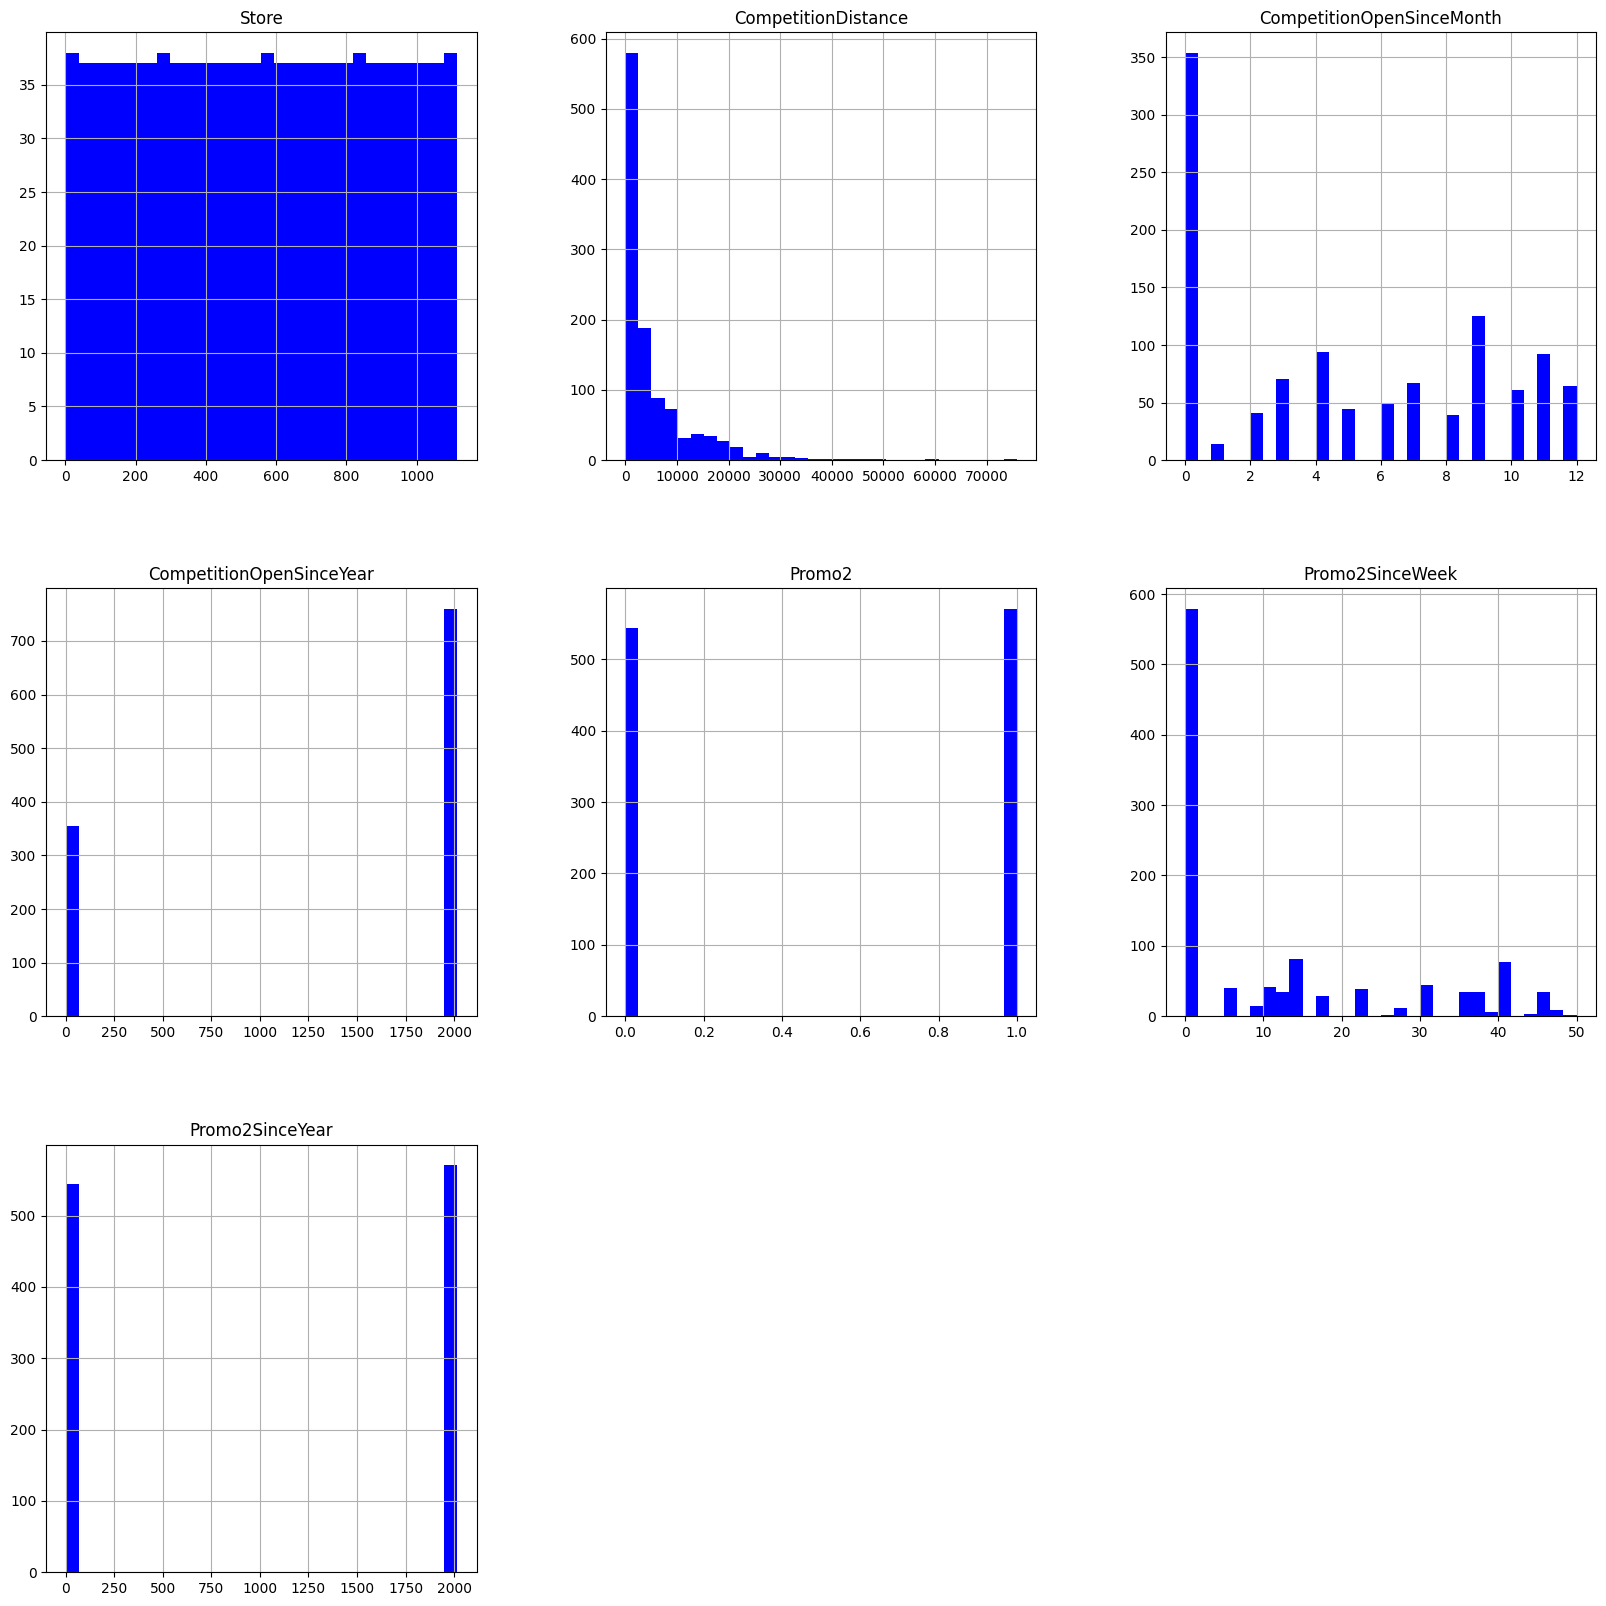

In [ ]:
store_info_df.hist(bins = 30, figsize=(20,20), color = 'b')

### Dados unidos (vendas + lojas)

In [ ]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [ ]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Unindo as duas tabelas através de um inner join pela coluna Store

In [ ]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store')

In [ ]:
sales_train_all_df.shape

(844392, 17)

In [ ]:
sales_train_all_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844391,292,3,2013-01-02,5076,672,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


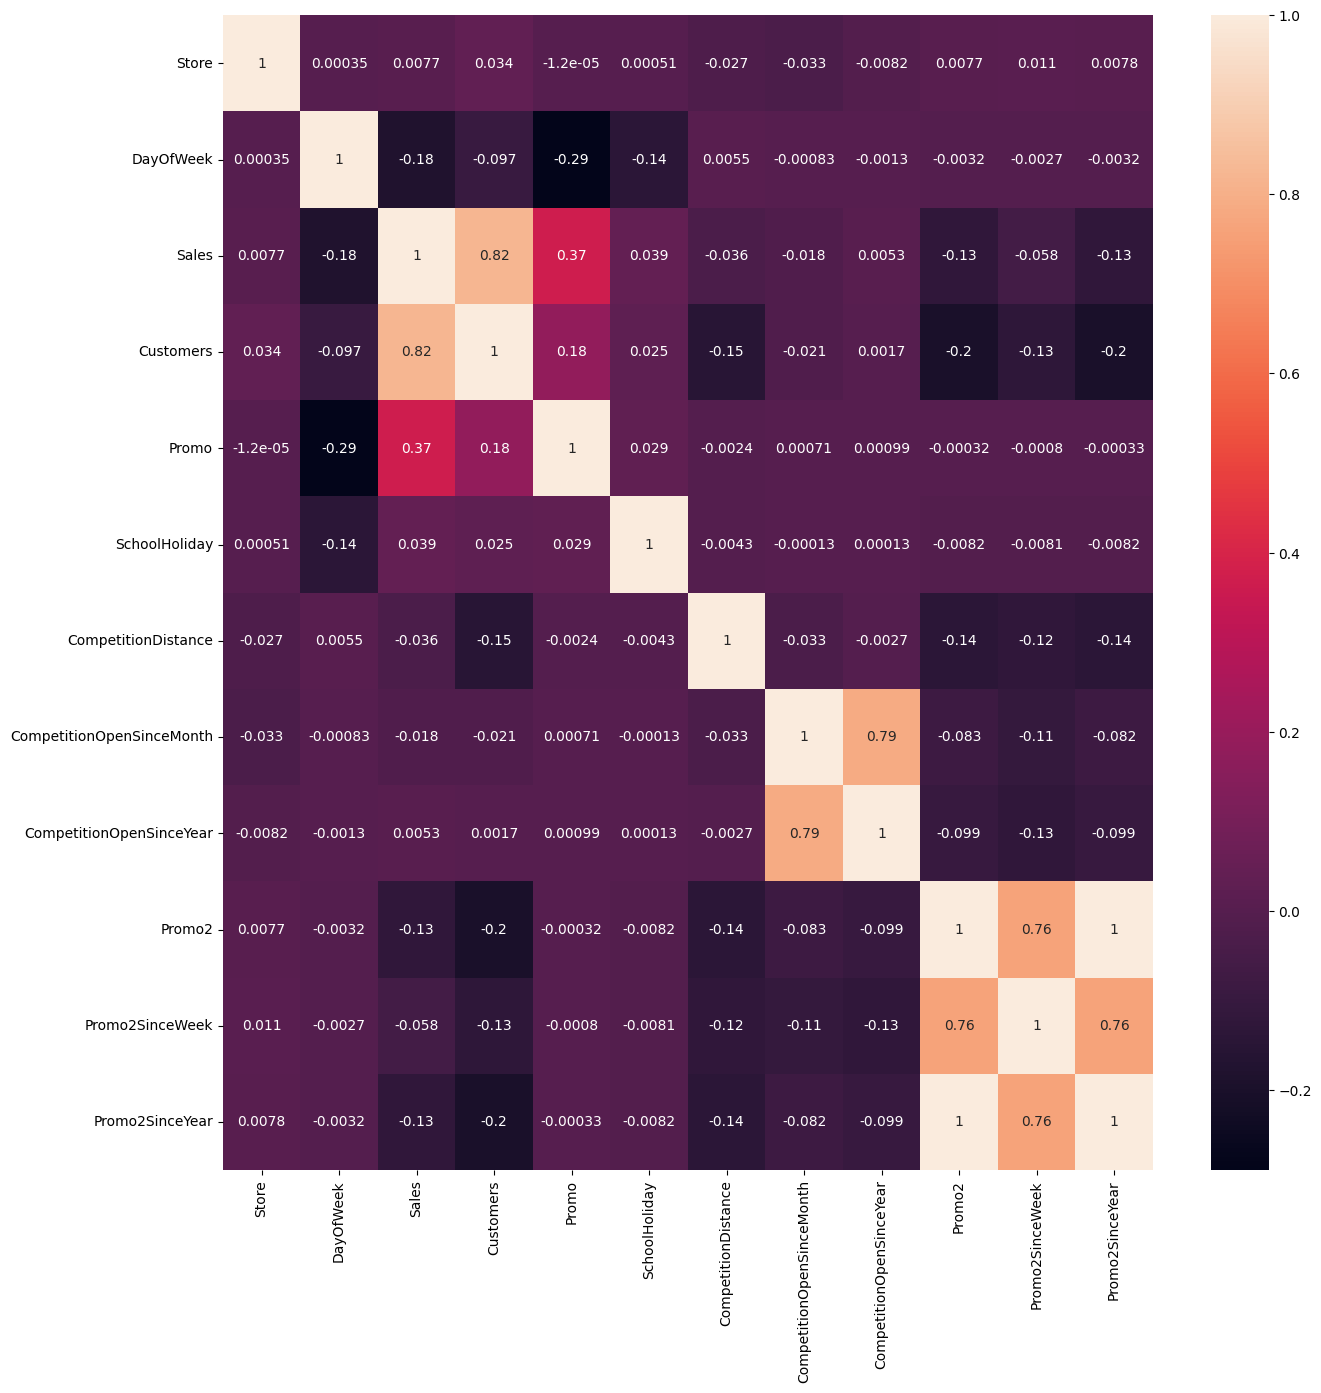

In [ ]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, annot = True);

Promo2 não afeta positivamente as vendas e quantidade de clientes por dia, pois possui uma correlação negativa com Sales e Customers. Então isso signifca que por mais que as lojas estivessem realizando promoções contínuas as vendas caíram e o número de clientes diminuiu.

In [ ]:
correlations = sales_train_all_df.corr()['Sales'].sort_values() # verificando a correlação somente para Sales
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

Naturalmente, a maior correlação de vendas é com Customers, pois quantos mais clientes por dia, mais vendas são feitas.

O atributo Date está dividio por mês, ano e dia. Para obsevarmos separadamente podemos criar um atributo para cada.

In [ ]:
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year # criando um atributo para o ano

In [ ]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015


In [ ]:
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month # criando atributo para o mês
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day # criando atributo para o dia

In [ ]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


Text(0.5, 1.0, 'Média de vendas por mês')

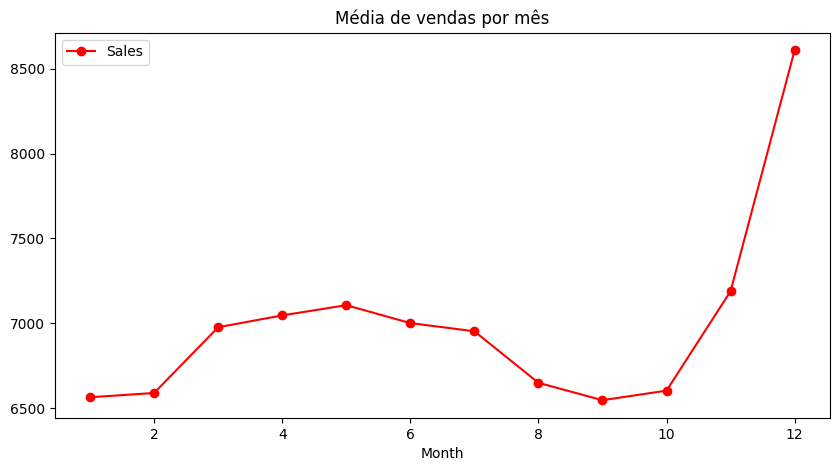

In [ ]:
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Média de vendas por mês')

- os meses mais lucrativos foram novembro e dezembro
- janeiro e fevereiro são os meses mais difíceis para as lojas com poucas vendas feitas
- de março a agosto a média de vendas esteve na casa dos 7000 euros aproxidamente

Text(0.5, 1.0, 'Média de clientes por mês')

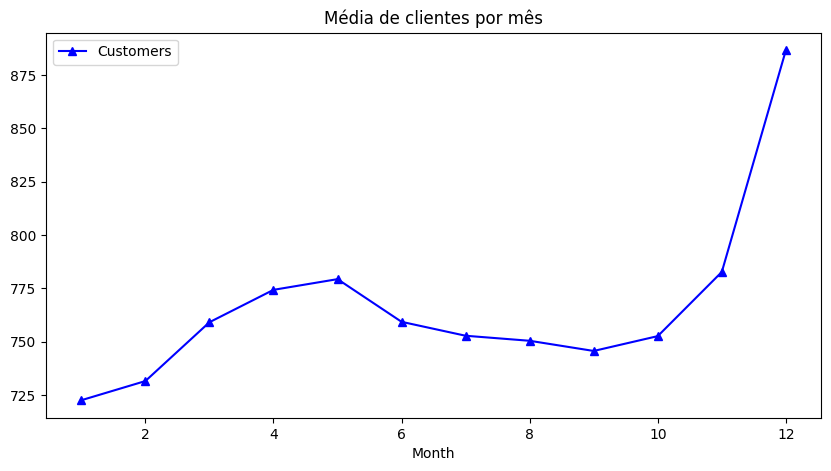

In [68]:
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por mês')

Text(0.5, 1.0, 'Média de vendas por dia')

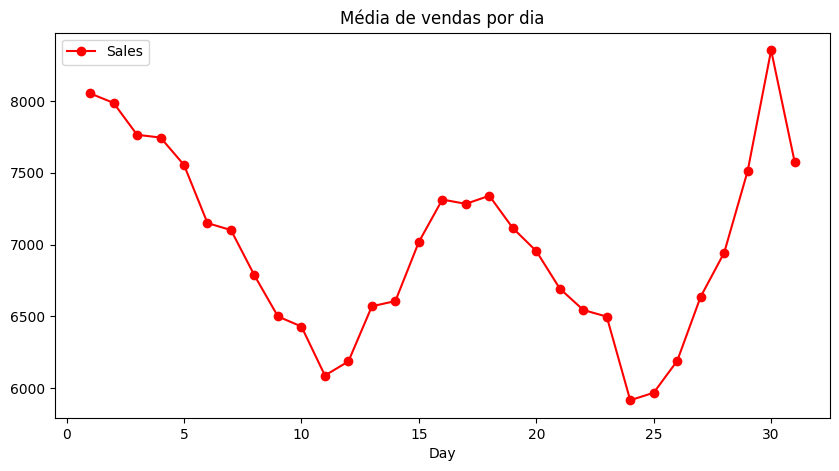

In [69]:
axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Média de vendas por dia')

- os valores mais altos de vendas se encontram no início e final de cada mês
- as vendas passam por um queda após o dia 5
- a partir do dia 10 as vendas voltam a subir e próximo do dia 20 voltam a cair
- a partir do dia 25 voltam ao subir e atingem o pico nos últimos dias do mês

Text(0.5, 1.0, 'Média de clientes por dia')

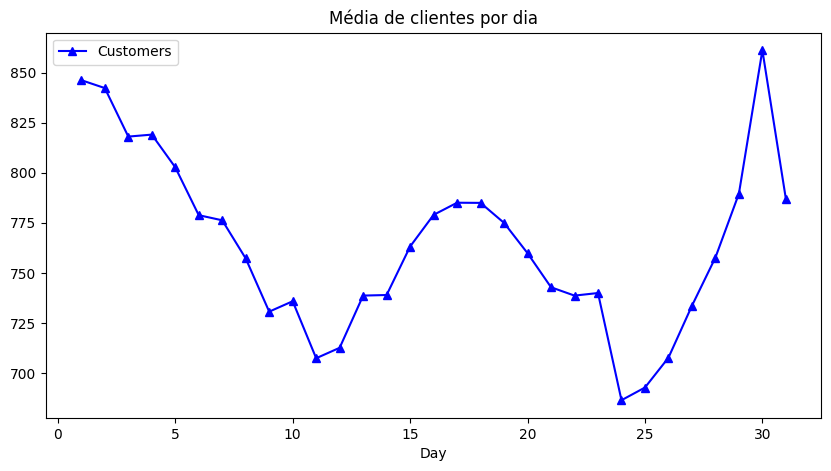

In [70]:
axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por dia')

- como há um relação com as vendas o número de clientes é maior no início e final de cada mês

Text(0.5, 1.0, 'Média de clientes por dia da semana')

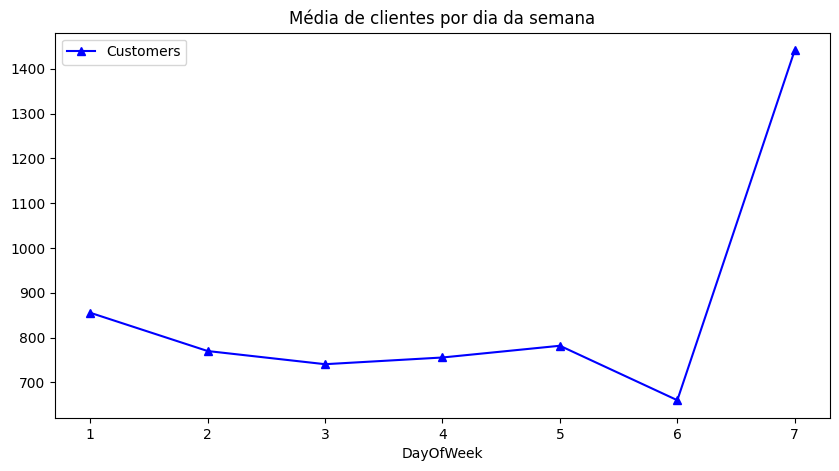

In [72]:
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por dia da semana')

<Axes: xlabel='Date'>

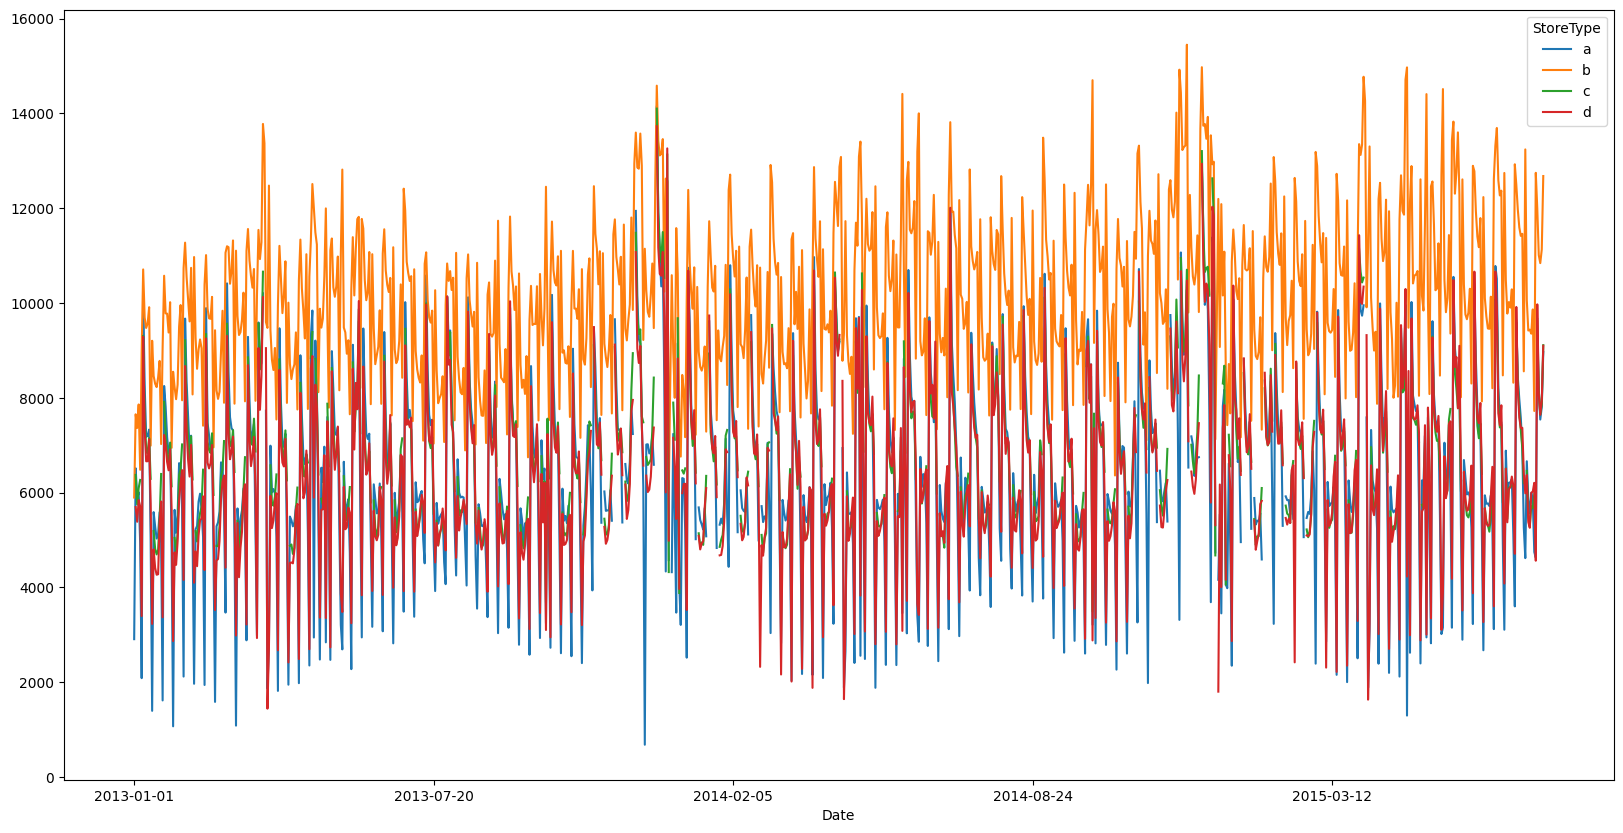

In [73]:
fig, ax = plt.subplots(figsize = (20,10))
sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

- a loja do tipo b tem os maiores valores de venda
- a loja do tipo a tem os menores valores de venda

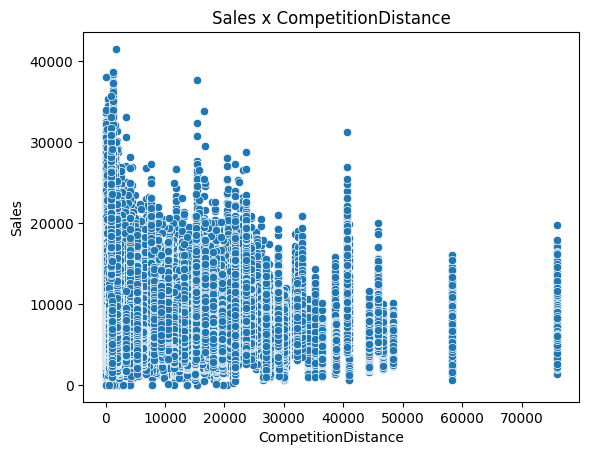

In [74]:
sns.scatterplot(data=sales_train_all_df, x="CompetitionDistance", y="Sales")
plt.title("Sales x CompetitionDistance")
plt.show()

- as vendas se mostram altas mesmo com distâncias menores da concorrência, então estar perto de lojas concorrentes não afeta negativamente as vendas

## Treinamento do modelo com Facebook Prophet

In [84]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
from prophet import Prophet

Vamos criar uma função para usar o algoritmo para fazer previsões em cada uma das lojas que passarmos para essa função.

In [93]:
# Date: ds
# Sales: y
# periods: quantos dias para frente queremos fazer a previsão

def sales_prediction(store_id, sales_df, periods):
  sales_df = sales_df[sales_df['Store']== store_id]
  sales_df = sales_df[['Date','Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  # instanciando modelo
  model = Prophet()
  # treinando o modelo
  model.fit(sales_df)
  # criando um df com as previsões
  future = model.make_future_dataframe(periods = periods)
  # realizando previsoes
  forecast = model.predict(future)
  # gerando figuras
  figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast



realizando uma previsão dos próximos 60 dias para a loja 10

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/7evzql11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/9p4yu097.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81866', 'data', 'file=/tmp/tmpfdsnes1k/7evzql11.json', 'init=/tmp/tmpfdsnes1k/9p4yu097.json', 'output', 'file=/tmp/tmpfdsnes1k/prophet_model9b02d6uj/prophet_model-20230516133137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


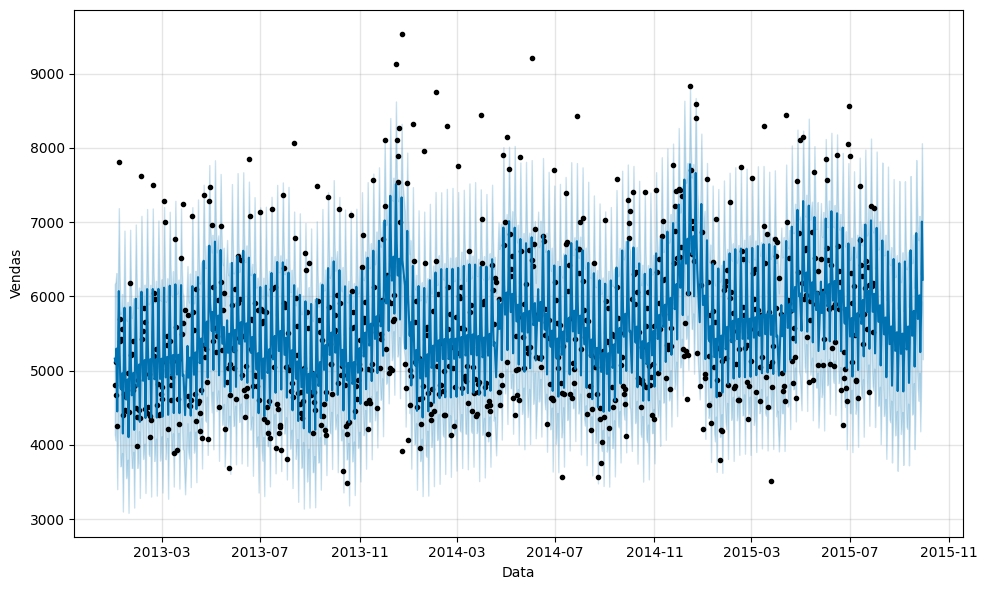

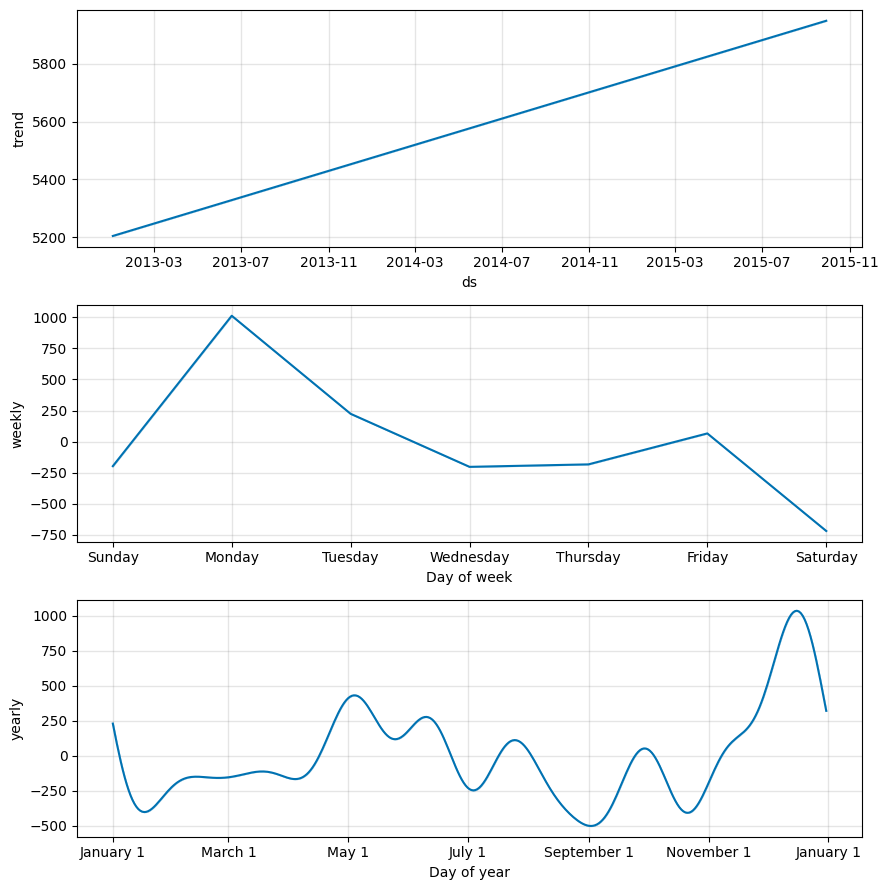

In [94]:
df_origin, df_prediction = sales_prediction(10, sales_train_all_df, 60)

- a figura trend mostra um crescimento de vendas de 2013 a 2015
- a figura weekly mostra que o sábado é o dia com menos vendas (já observado anteriormente)
- a figura yearly mostra que novembro e dezembro são os meses mais lucrativos (já observado anteriormente)


In [95]:
df_origin.shape, df_prediction.shape

((784, 2), (844, 19))

Existem alguns atributos interessantes no df com as previsões. **trend** mostra a tendência de vendas. **trend_upper** mostra a tendência do maior valor e **trend_lower** a tendência do menor valor de vendas. **yhat_lower** mostra o menor valor e **yhat_upper** o maior valor de vendas.

E **yhat** é de fato o atributo com os valores preditos para as vendas em cada data.

In [96]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5204.486658,4141.888888,6166.089731,5204.486658,5204.486658,-43.902335,-43.902335,-43.902335,-203.049769,-203.049769,-203.049769,159.147434,159.147434,159.147434,0.0,0.0,0.0,5160.584323
1,2013-01-03,5205.230730,4059.348665,6193.991697,5205.230730,5205.230730,-93.003041,-93.003041,-93.003041,-183.141466,-183.141466,-183.141466,90.138426,90.138426,90.138426,0.0,0.0,0.0,5112.227689
2,2013-01-04,5205.974802,4251.163632,6312.099206,5205.974802,5205.974802,90.019950,90.019950,90.019950,65.957031,65.957031,65.957031,24.062919,24.062919,24.062919,0.0,0.0,0.0,5295.994752
3,2013-01-05,5206.718874,3401.707447,5499.305270,5206.718874,5206.718874,-757.470619,-757.470619,-757.470619,-719.018375,-719.018375,-719.018375,-38.452244,-38.452244,-38.452244,0.0,0.0,0.0,4449.248255
4,2013-01-07,5208.207018,5067.262505,7187.390724,5208.207018,5208.207018,862.164867,862.164867,862.164867,1012.862453,1012.862453,1012.862453,-150.697586,-150.697586,-150.697586,0.0,0.0,0.0,6070.371885


In [97]:
# observando qual a última data no df original
df_origin.tail()

,ds,y
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186
7036,2015-07-31,7185


A data mais recente da base é 31 do 07 de 2015.

Vamos ver quais as previsões para os próximos 60 dias.

In [98]:
df_prediction.tail(60)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
784,2015-08-01,5905.001137,4238.989218,6374.522021,5905.001137,5905.001137,-673.953022,-673.953022,-673.953022,-719.018375,-719.018375,-719.018375,45.065353,45.065353,45.065353,0.0,0.0,0.0,5231.048115
785,2015-08-02,5905.745667,4677.791434,6857.991968,5905.745667,5905.745667,-172.686247,-172.686247,-172.686247,-197.385833,-197.385833,-197.385833,24.699586,24.699586,24.699586,0.0,0.0,0.0,5733.059420
786,2015-08-03,5906.490196,5824.223509,7949.965422,5906.490196,5906.490196,1015.438492,1015.438492,1015.438492,1012.862453,1012.862453,1012.862453,2.576039,2.576039,2.576039,0.0,0.0,0.0,6921.928688
787,2015-08-04,5907.234726,5043.752360,7062.566489,5907.234726,5907.234726,202.830805,202.830805,202.830805,223.775958,223.775958,223.775958,-20.945153,-20.945153,-20.945153,0.0,0.0,0.0,6110.065531
788,2015-08-05,5907.979256,4524.809986,6629.131183,5907.979256,5907.979256,-248.556855,-248.556855,-248.556855,-203.049769,-203.049769,-203.049769,-45.507086,-45.507086,-45.507086,0.0,0.0,0.0,5659.422401
789,2015-08-06,5908.723785,4537.209545,6680.667172,5908.723785,5908.723785,-253.906331,-253.906331,-253.906331,-183.141466,-183.141466,-183.141466,-70.764864,-70.764864,-70.764864,0.0,0.0,0.0,5654.817455
790,2015-08-07,5909.468315,4781.593764,7012.921284,5909.468315,5909.468315,-30.436427,-30.436427,-30.436427,65.957031,65.957031,65.957031,-96.393458,-96.393458,-96.393458,0.0,0.0,0.0,5879.031888
791,2015-08-08,5910.212845,4009.787005,6083.877729,5910.212845,5910.212846,-841.112806,-841.112806,-841.112806,-719.018375,-719.018375,-719.018375,-122.094432,-122.094432,-122.094432,0.0,0.0,0.0,5069.100038
792,2015-08-09,5910.957375,4574.268295,6585.324590,5910.957375,5910.957382,-344.987201,-344.987201,-344.987201,-197.385833,-197.385833,-197.385833,-147.601368,-147.601368,-147.601368,0.0,0.0,0.0,5565.970174
793,2015-08-10,5911.701904,5662.233728,7801.811915,5911.701900,5911.701917,840.178570,840.178570,840.178570,1012.862453,1012.862453,1012.862453,-172.683883,-172.683883,-172.683883,0.0,0.0,0.0,6751.880474


In [99]:
df_prediction['Day'] = pd.DatetimeIndex(df_prediction['ds']).day # criando atributo para o dia

<Axes: xlabel='Day', ylabel='yhat'>

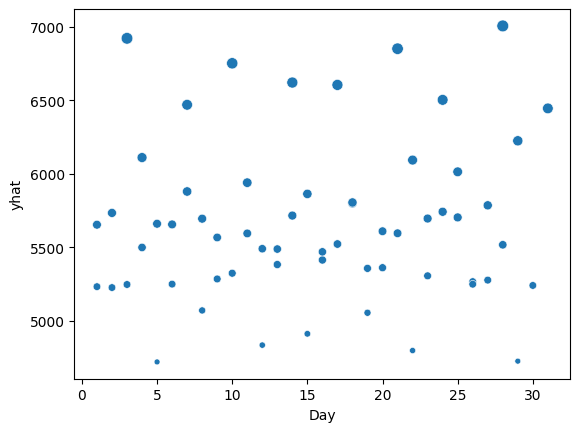

In [135]:
sns.scatterplot(data=df_prediction.tail(60), x="Day", y="yhat", size='yhat',legend=None)

- no geral, não parece que irá haver um crescimento ou uma queda no volume de vendas para o próximos 60 dias

In [136]:
df_prediction.tail(60).to_csv('previsoes_vendas.csv') # salvando as previsoes de cada data em um arquivo csv

## Treinamento do modelo - com feriados



   - StateHoliday: Normalmente todas as lojas estão fechadas nesses feriados. As escolas estão fechadas nesses feriados e nos finais de semana. Legenda: a = public holiday, b = Páscoa, c = Natal, 0 = Nenhum feriado
   - SchoolHoliday: indica se a loja foi afetada pelo feriado escolar
  






In [137]:
def sales_prediction(store_id, sales_df, holidays, periods):
  sales_df = sales_df[sales_df['Store'] == store_id]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df.sort_values(by = 'ds')

  model = Prophet(holidays=holidays)
  model.fit(sales_df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
  figure2 = model.plot_components(forecast)

  return sales_df, forecast

In [138]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [139]:
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [140]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [141]:
len(np.unique(school_holidays))

477

Pegando os feriados estaduais

In [142]:
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a') | 
                                    (sales_train_all_df['StateHoliday'] == 'b') |
                                    (sales_train_all_df['StateHoliday'] == 'c')].loc[:,'Date'].values

In [143]:
state_holidays.shape

(910,)

In [145]:
len(np.unique(state_holidays))

35

In [146]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


Pegando os feriados escolares

In [147]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [148]:
school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/k6x8rya0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfdsnes1k/xz9hed02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33367', 'data', 'file=/tmp/tmpfdsnes1k/k6x8rya0.json', 'init=/tmp/tmpfdsnes1k/xz9hed02.json', 'output', 'file=/tmp/tmpfdsnes1k/prophet_modelri39st7g/prophet_model-20230516145235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


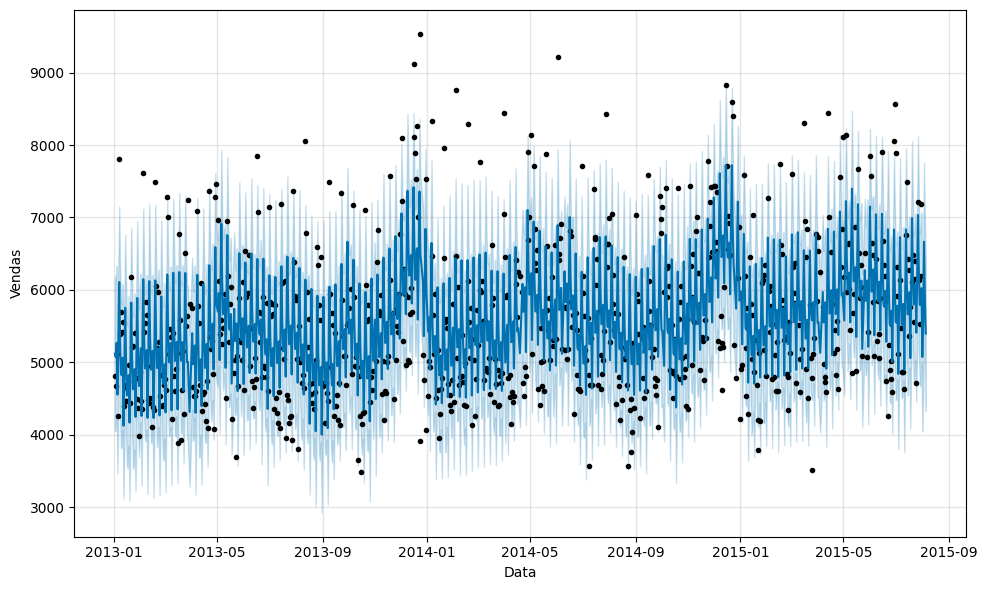

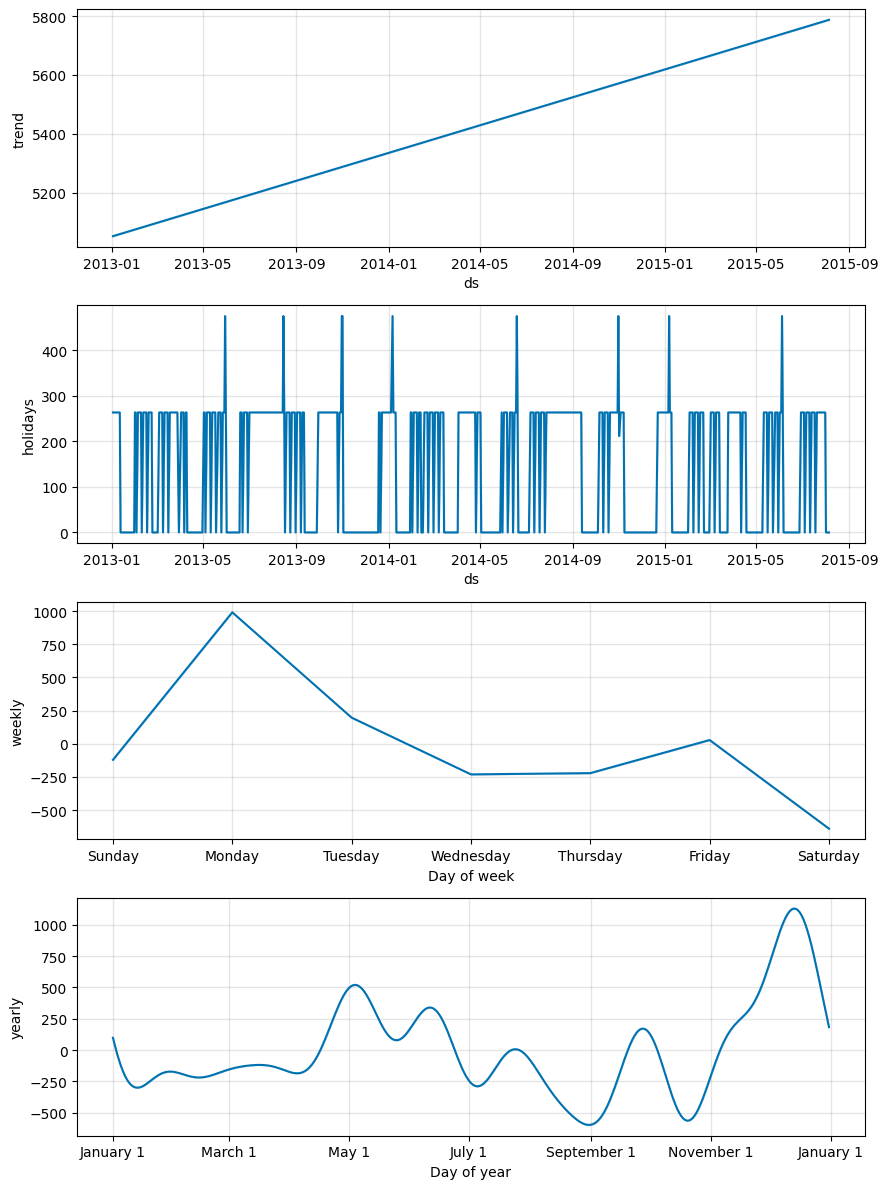

In [149]:
df_original, df_prediction = sales_prediction(10, sales_train_all_df, school_state_holidays, 5)

No gráfico holidays (feriados) o Prophet identificou picos de vendas em alguns meses específicos como a páscoa (5 e 6) e agosto e setembro (8 e 9)

In [156]:
df_prediction.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
784,2015-08-01,5783.976755,4043.980691,6087.045791,5783.976755,5783.976755,-709.755395,-709.755395,-709.755395,0.0,...,-640.411806,-640.411806,-640.411806,-69.343589,-69.343589,-69.343589,0.0,0.0,0.0,5074.221359
785,2015-08-02,5784.753694,4519.202781,6588.931866,5784.753694,5784.753694,-211.481739,-211.481739,-211.481739,0.0,...,-121.536030,-121.536030,-121.536030,-89.945709,-89.945709,-89.945709,0.0,0.0,0.0,5573.271955
786,2015-08-03,5785.530634,5620.862102,7754.513942,5785.530634,5785.530634,878.548315,878.548315,878.548315,0.0,...,990.568234,990.568234,990.568234,-112.019919,-112.019919,-112.019919,0.0,0.0,0.0,6664.078949
787,2015-08-04,5786.307573,4911.024110,6937.217823,5786.307573,5786.307573,61.333228,61.333228,61.333228,0.0,...,196.551123,196.551123,196.551123,-135.217895,-135.217895,-135.217895,0.0,0.0,0.0,5847.640801
788,2015-08-05,5787.084513,4326.630339,6412.892620,5787.084513,5787.084513,-390.419365,-390.419365,-390.419365,0.0,...,-231.215361,-231.215361,-231.215361,-159.204004,-159.204004,-159.204004,0.0,0.0,0.0,5396.665148


In [160]:
df_prediction['Day'] = pd.DatetimeIndex(df_prediction['ds']).day 

Text(0.5, 1.0, 'Previsão para os próximos 5 dias')

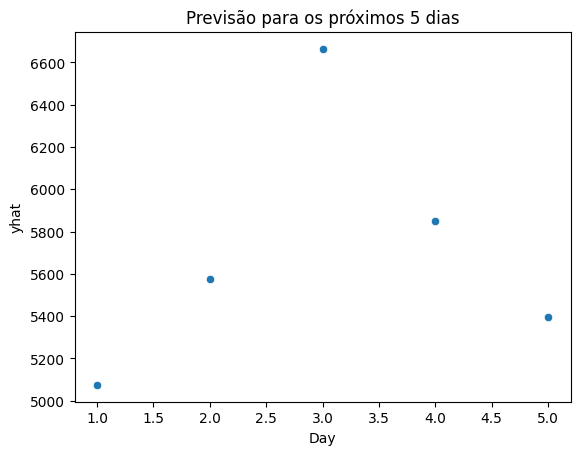

In [165]:
sns.scatterplot(data=df_prediction.tail(5), x="Day", y="yhat",legend=None)
plt.title("Previsão para os próximos 5 dias")

- no dia 3 haverá um pico de vendas
- no dia 1 as vendas serão baixas